In [2]:
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine, text, MetaData
from sqlalchemy.exc import IntegrityError
import numpy as np

In [3]:
engine = create_engine('postgres:///piwheels')
conn = engine.connect()
meta = MetaData()
meta.bind = conn
meta.reflect(views=True)

/home/piwheels/.virtualenvs/stats/lib/python3.6/site-packages/sqlalchemy/dialects/postgresql/base.py:3470: SAWarning: Predicate of partial index files_size ignored during reflection
  % idx_name


In [4]:
start_date = '2020-04-01'
end_date = '2020-06-30'

In [5]:
pd.read_sql(f"""
    SELECT COUNT(*) AS downloads
    FROM downloads
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
""", conn)

,downloads
0,3631509


In [101]:
downloads_by_month = pd.read_sql(f"""
    SELECT date_trunc('month', accessed_at) m, COUNT(*) AS c
    FROM downloads
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
    GROUP BY m
    ORDER BY m
""", conn)

downloads_by_month

,m,c
0,2020-04-01,1239168
1,2020-05-01,1271663
2,2020-06-01,1120678


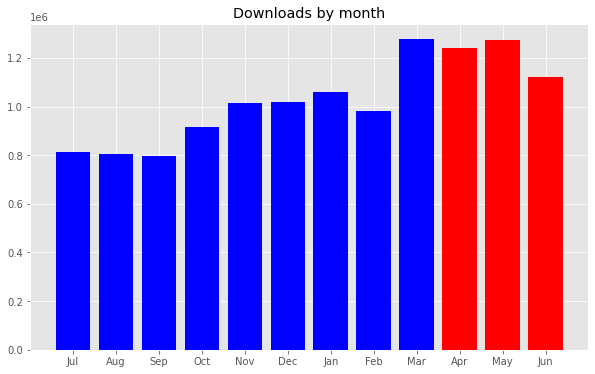

In [102]:
plt.rcParams["figure.figsize"] = (10, 6)

downloads = {
    'Jul': 814607,
    'Aug': 804750,
    'Sep': 795325,
    'Oct': 913798,
    'Nov': 1014577,
    'Dec': 1017563,
    'Jan': 1060112,
    'Feb': 980532,
    'Mar': 1276799,
    'Apr': downloads_by_month.c[0],
    'May': downloads_by_month.c[1],
    'Jun': downloads_by_month.c[2],
}

colors = ['blue']*9 + ['red']*3
plt.bar(range(len(downloads)), downloads.values(), color=colors)
plt.title('Downloads by month')
plt.xticks(range(len(downloads)), list(downloads.keys()))

plt.savefig('downloads-by-month.png')

plt.show()

In [9]:
pd.read_sql(f"""
    SELECT COUNT(*) AS searches
    FROM searches
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
""", conn)

,searches
0,32033978


In [10]:
pd.read_sql(f"""
    SELECT date_trunc('month', accessed_at) AS month, COUNT(*) AS searches
    FROM searches
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
    GROUP BY month
    ORDER BY month
""", conn)

,month,searches
0,2020-04-01,10428233
1,2020-05-01,10841076
2,2020-06-01,10764669


In [107]:
downloads_by_day = pd.read_sql(f"""
    SELECT accessed_at::date AS d, COUNT(*) AS downloads
    FROM downloads
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
    GROUP BY d
    ORDER BY d
""", conn)

df

,day,searches
0,2020-04-01,345489
1,2020-04-02,319725
2,2020-04-03,334385
3,2020-04-04,331875
4,2020-04-05,340062
...,...,...
86,2020-06-26,341257
87,2020-06-27,313979
88,2020-06-28,346689
89,2020-06-29,340698


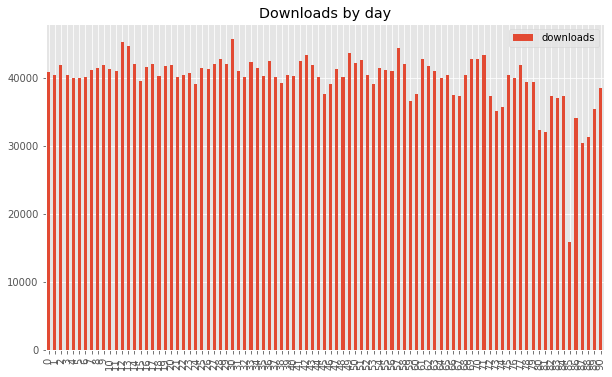

In [114]:
p = downloads_by_day.plot.bar(title='Downloads by day')
p.figure.savefig('downloads-by-day.png')

In [115]:
searches_by_day = pd.read_sql(f"""
    SELECT accessed_at::date AS day, COUNT(*) AS searches
    FROM searches
    WHERE accessed_at::date BETWEEN '{start_date}' AND '{end_date}'
    GROUP BY day
    ORDER BY day
""", conn)

df

,day,searches
0,2020-04-01,345489
1,2020-04-02,319725
2,2020-04-03,334385
3,2020-04-04,331875
4,2020-04-05,340062
...,...,...
86,2020-06-26,341257
87,2020-06-27,313979
88,2020-06-28,346689
89,2020-06-29,340698


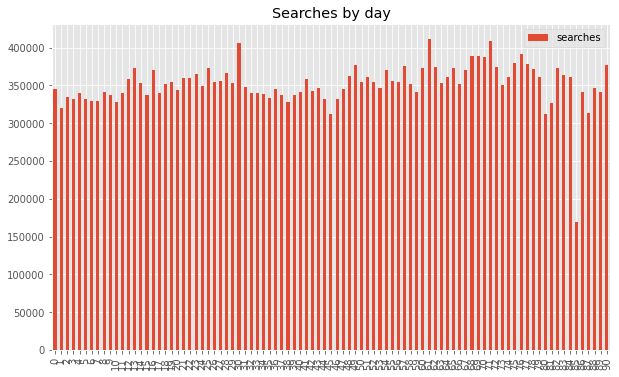

In [116]:
p = df.plot.bar(title='Searches by day')
p.figure.savefig('searches-by-day.png')

In [20]:
pd.read_sql(f"""
    SELECT JUSTIFY_INTERVAL(SUM(
        CASE f.platform_tag
            WHEN 'linux_armv7l' THEN 1                           
            WHEN 'linux_armv6l' THEN 6                                                       
            ELSE 0           
        END *
        CASE                        
            WHEN b.duration > INTERVAL '1 week' THEN INTERVAL '0'
            WHEN b.duration > INTERVAL '6.7 seconds' THEN b.duration - INTERVAL '6.7 seconds'
            ELSE INTERVAL '0'               
        END                  
        )) AS total_time_saved_in_quarter                        
    FROM downloads d
    JOIN files f ON d.filename = f.filename
    JOIN builds b ON b.build_id = f.build_id
    WHERE f.abi_tag <> 'none'
    AND d.accessed_at::date between '{start_date}' and '{end_date}'
""", conn)

,total_time_saved_in_quarter
0,25996 days 22:33:44.131687


In [21]:
pd.read_sql(f"""
    SELECT date_trunc('month', d.accessed_at) as month, JUSTIFY_INTERVAL(SUM(
        CASE f.platform_tag
            WHEN 'linux_armv7l' THEN 1
            WHEN 'linux_armv6l' THEN 6
            ELSE 0
        END *
        CASE
            WHEN b.duration > INTERVAL '1 week' THEN INTERVAL '0'
            WHEN b.duration > INTERVAL '6.7 seconds' THEN b.duration - INTERVAL '6.7 seconds'
            ELSE INTERVAL '0'
        END
            )) AS time_saved_in_month
    FROM downloads d
    JOIN files f ON d.filename = f.filename
    JOIN builds b ON b.build_id = f.build_id
    WHERE f.abi_tag <> 'none'
    AND d.accessed_at::date between '{start_date}' and '{end_date}'
    GROUP BY month
    ORDER BY month
""", conn)

,month,time_saved_in_month
0,2020-04-01,7979 days 11:21:10.828580
1,2020-05-01,9256 days 05:45:50.646303
2,2020-06-01,8751 days 05:26:42.656804


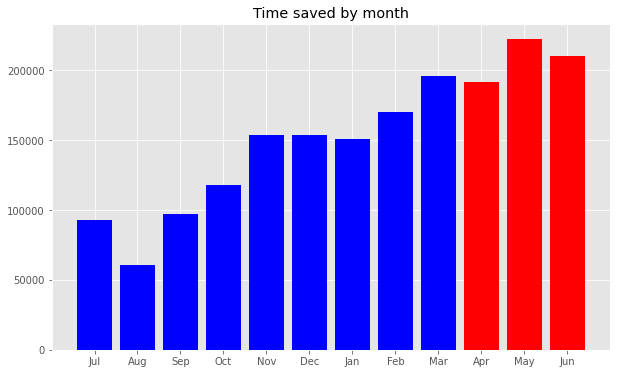

In [22]:
time_saved = {
    'Jul': 92737,
    'Aug': 60992,
    'Sep': 97272,
    'Oct': 118188,
    'Nov': 153604,
    'Dec': 153948,
    'Jan': 150659,
    'Feb': 169774,
    'Mar': 196052,
    'Apr': 191496,
    'May': 222144,
    'Jun': 210024,
}

colors = ['blue']*9 + ['red']*3
plt.bar(range(len(time_saved)), time_saved.values(), color=colors)
plt.title('Time saved by month')
plt.xticks(range(len(time_saved)), list(time_saved.keys()))

plt.savefig('time-saved-by-month.png')

plt.show()

In [24]:
pd.read_sql(f"""
    select b.package, count(*) c
    from downloads d
    join files f on f.filename = d.filename
    join builds b on b.build_id = f.build_id
    where accessed_at::date between '{start_date}' and '{end_date}'
    group by b.package
    order by c desc
    limit 10;
""", conn)

,package,c
0,Flask-Login,130830
1,PyYAML,94638
2,Markdown,93945
3,semantic-version,93309
4,sentry-sdk,93164
5,cffi,86801
6,pycparser,81878
7,numpy,81279
8,zope.component,74446
9,cryptography,57608


In [31]:
pd.read_sql(f"""
    select package, count(*) c
    from searches
    where accessed_at::date between '{start_date}' and '{end_date}'
    group by package
    order by c desc
    limit 10;
""", conn)

,package,c
0,pip,2583198
1,setuptools,896893
2,wheel,759387
3,requests,541003
4,youtube-dl,502525
5,certifi,494112
6,urllib3,476375
7,six,431755
8,idna,362577
9,pytz,350693


In [34]:
pd.read_sql(f"""
    select package, count(*) c
    from searches
    where accessed_at::date between '{start_date}' and '{end_date}'
    and package in ('gpiozero', 'rpi-gpio', 'picamera', 'pigpio', 'pyjokes', 'guizero', 'piwheels', 'lars', 'sense-hat', 'sense-emu')
    group by package
    order by c desc
    limit 10;
""", conn)

,package,c
0,rpi-gpio,98507
1,picamera,42893
2,gpiozero,24431
3,pigpio,20439
4,sense-hat,10410
5,guizero,6729
6,sense-emu,5392
7,pyjokes,625
8,piwheels,105
9,lars,5


In [61]:
pd.read_sql(f"""
    select os_name, count(*) c
    from searches
    where accessed_at::date between '{start_date}' and '{end_date}'
    group by os_name
    order by c desc
    limit 3
""", conn)

,os_name,c
0,Linux,31964825
1,Windows,41410
2,Darwin,27651


In [62]:
df = pd.read_sql(f"""
    select distro_name, count(*) c
    from searches
    where accessed_at::date between '{start_date}' and '{end_date}'
    and os_name = 'Linux'
    group by distro_name
    order by c desc
    limit 3
""", conn)

df

,distro_name,c
0,Raspbian GNU/Linux,30315489
1,Debian GNU/Linux,1140956
2,Ubuntu,400922


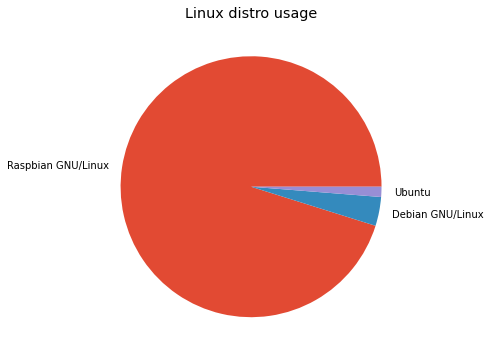

In [63]:
plt.pie(df.c, labels=df.distro_name)
plt.title('Linux distro usage')

plt.savefig('distro-usage.png')

plt.show()

In [64]:
df = pd.read_sql(f"""
    select distro_version, count(*) c
    from searches
    where accessed_at::date between '{start_date}' and '{end_date}'
    and os_name = 'Linux'
    and distro_name in ('Raspbian GNU/Linux', 'Debian GNU/Linux')
    and distro_version in ('8', '9', '10')
    group by distro_version
    order by c desc
""", conn)

df

,distro_version,c
0,10,23457804
1,9,7849582
2,8,3755


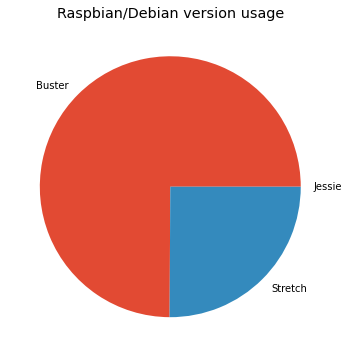

In [66]:
version_names = {'10': 'Buster', '9': 'Stretch', '8': 'Jessie'}
plt.pie(df.c, labels=[version_names[v] for v in df.distro_version])
plt.title('Raspbian/Debian version usage')

plt.savefig('debian-usage.png')

plt.show()

In [125]:
arch = pd.read_sql(f"""
    select arch, count(*) c
    from searches
    where accessed_at::date between '{start_date}' and '{end_date}'
    group by arch
    order by c desc
""", conn)

arch

,arch,c
0,armv7l,28746040
1,armv6l,2064715
2,x86_64,687139
3,aarch64,416249
4,i686,78074
5,AMD64,41408
6,armv8l,256
7,None,91
8,arm,4
9,x86,2


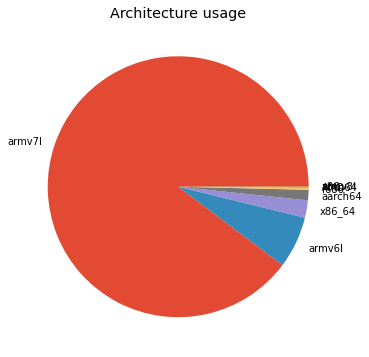

In [126]:
plt.pie(arch.c, labels=arch.arch)
plt.title('Architecture usage')

plt.savefig('arch.png')

plt.show()

In [127]:
arm_arch = pd.read_sql(f"""
    select arch, count(*) c
    from searches
    where accessed_at::date between '{start_date}' and '{end_date}'
    and os_name = 'Linux'
    and distro_name in ('Raspbian GNU/Linux', 'Debian GNU/Linux')
    and arch in ('armv6l', 'armv7l', 'aarch64')
    group by arch
    order by c desc
""", conn)

arch

KeyboardInterrupt: 

In [ ]:
plt.pie(arm_arch.c, labels=arm_arch.arch)
plt.title('Raspbian/Debian Arm architecture usage')

plt.savefig('debian-arch.png')

plt.show()

In [121]:
py_vers = pd.read_sql(f"""
    select substring(py_version from 1 for 3) pyver, count(*) c
    from searches
    where accessed_at::date between '{start_date}' and '{end_date}'
    and py_name = 'CPython'
    group by pyver
    order by c desc
    limit 5
""", conn)

py_vers

,pyver,c
0,3.7,16373393
1,2.7,11211993
2,3.5,2778136
3,3.8,1049887
4,3.6,605774


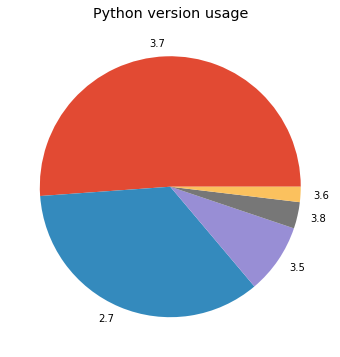

In [122]:
plt.pie(py_vers.c, labels=py_vers.pyver)
plt.title('Python version usage')

plt.savefig('py-vers.png')

plt.show()

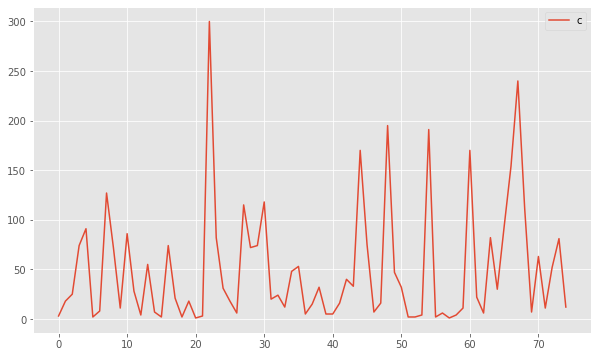

In [93]:
jessie_searches = pd.read_sql(f"""
    select accessed_at::date as day, count(*) c
    from searches
    where accessed_at::date between '{start_date}' and '{end_date}'
    and os_name = 'Linux'
    and distro_name in ('Raspbian GNU/Linux', 'Debian GNU/Linux')
    and distro_version = '8'
    group by day
    order by day
""", conn)

jessie_searches.plot()

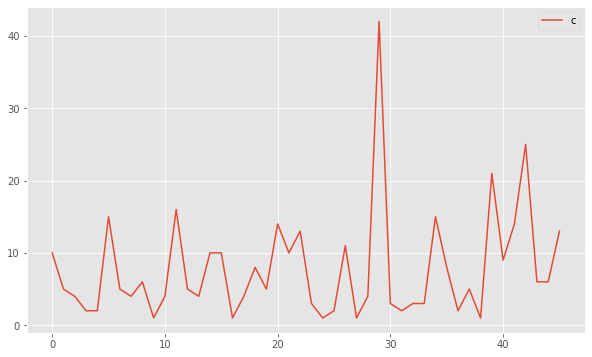

In [94]:
jessie_downloads = pd.read_sql(f"""
    select accessed_at::date as day, count(*) c
    from downloads
    where accessed_at::date between '{start_date}' and '{end_date}'
    and os_name = 'Linux'
    and distro_name in ('Raspbian GNU/Linux', 'Debian GNU/Linux')
    and distro_version = '8'
    group by day
    order by day
""", conn)

jessie_downloads.plot()

In [128]:
pip_versions = pd.read_sql(f"""
    select installer_version, count(*) c
    from searches
    where accessed_at::date between '{start_date}' and '{end_date}'
    and installer_name = 'pip'
    and installer_version is not null
    group by installer_version
    order by c desc
""", conn)

pip_versions[:10]

,installer_version,c
0,18.1,10317956
1,9.0.1,5406456
2,20.1.1,4741246
3,20.0.2,3885306
4,19.3.1,2746288
5,20.1,2501631
6,19.2.3,915949
7,19.0.1,404222
8,19.1.1,293714
9,9.0.3,213349


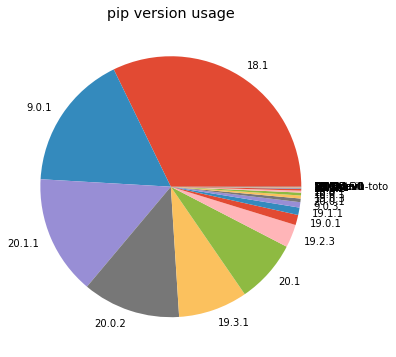

In [129]:
plt.pie(pip_versions.c, labels=pip_versions.installer_version)
plt.title('pip version usage')

plt.savefig('pip-vers.png')

plt.show()

In [131]:
setuptools_versions = pd.read_sql(f"""
    select setuptools_version, count(*) c
    from searches
    where accessed_at::date between '{start_date}' and '{end_date}'
    and installer_name = 'pip'
    and setuptools_version is not null
    group by setuptools_version
    order by c desc
""", conn)

setuptools_versions[:10]

,setuptools_version,c
0,40.8.0,12619926
1,46.1.3,2791126
2,41.5.1,1620448
3,41.2.0,1170652
4,46.4.0,1011978
5,44.1.0,926089
6,47.1.1,923071
7,42.0.2,890662
8,47.3.1,597911
9,33.1.1,474641


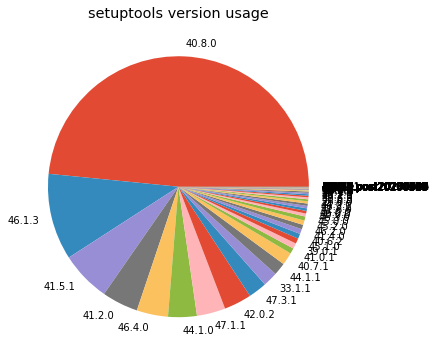

In [132]:
plt.pie(setuptools_versions.c, labels=setuptools_versions.setuptools_version)
plt.title('setuptools version usage')

plt.savefig('setuptools-vers.png')

plt.show()